<a href="https://colab.research.google.com/github/antontmoore/graph_search_algorithms/blob/master/Algorithms_on_graphs_Tutorial_(rus).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Поиск в глубину, поиск в ширину, алгоритмы Дейкстры и А* — это один и тот же алгоритм.
В алгоритмических задачах на графах мы часто используем четыре известных алгоритма. Два из них — это алгоритмы обхода графа: Поиск в ширину и Поиск в глубину. Ещё два, A* и алгоритм Дейкстры, используются для нахождения оптимального пути внутри графа от одного узла до другого.

Я покажу, что все эти четыре алгоритма — это по сути один и тот же алгоритм. И вся разница между ними — только в разных структурах данных, используемых для хранения непосещённых узлов графа. 


# Импорт всего необходимого

Склонируем репозиторий с кодом из github-репозитория и зайдём в директорию проекта.

In [21]:
!git clone https://github.com/antontmoore/graph_search_algorithms


import os
if os.getcwd() == '/content':
  os.chdir('graph_search_algorithms')

fatal: destination path 'graph_search_algorithms' already exists and is not an empty directory.


Импортируем всё, что нам понадобится.

In [22]:
from networkx import Graph
from utils import generate_simple_graph, generate_maze_graph, print_path
from utils.graph_animation import GraphAnimator
from utils.data_structures import AbstractNodeStorageClass
from utils.data_structures import Stack, Queue, DijkstraQueue, AStarQueue
from heapq import heappush, heappop
from math import sqrt

# Задачка для примера. Поиск пути внутри небольшого графа.

Сначала рассмотрим задачу поиска пути в небольшом простом графе. Двигаясь от узла к узлу, мы хотим найти путь от *start* до *target*.


In [23]:
# Сгенерируем небольшой граф для тестовой задачи
graph, start_node, target_node = generate_simple_graph()

# А также вспомогательный класс GraphAnimator. 
# Он поможет нам делать красивую анимацию.
graph_animator = GraphAnimator(graph, start_node, target_node)

# Посмотрим на наш граф.
fig = graph_animator.make_one_shot()
fig.show()   

# Тот самый один алгоритм

Ниже описан алгоритм обхода графа. Как мы увидим ниже, он действует по-разному в зависимости от того, какую структуру данных он использует.

In [24]:
def find_path(
        graph: Graph,
        start_node: int,
        target_node: int,
        nodes_storage_structure_name: str,
        animator: GraphAnimator
    ):
    """
      Универсальный алгоритм обхода графа в поисках пути между начальным (start)
      и целевым (target) узлами. Он использует структуру графа и вспомогательную
      структуру nodes_storage.
      Передаваемый функции animator используется для создания анимаций того, как
      работает алгоритм в процессе поиска пути.
    """

    color = ['white'] * graph.number_of_nodes()      # красим все узлы в белый
    dist = [float('Inf')] * graph.number_of_nodes()  # на старте все расстояния ∞
    parent = dict()                                  # словарь {node : его родитель}

    nodes_storage = {
        'Stack': Stack(),
        'Queue': Queue(),
        'DijkstraQueue': DijkstraQueue(dist),
        'AStarQueue': AStarQueue(graph, dist, target_node)
    }[nodes_storage_structure_name]

    # кладём start_node внутрь nodes_storage
    nodes_storage.insert(start_node)
    dist[start_node] = 0
    animator.add_frame(color, parent, start_node, nodes_storage)

    # Цикл пока внутри nodes_storage есть узлы
    while not nodes_storage.is_empty():
        current_node = nodes_storage.get_first()

        if current_node == target_node:
            # Конец поиска, целевой узел найден, а значит и путь до него
            print_path(target_node, parent)
            animator.add_frame(color, parent, current_node, nodes_storage)
            break

        # возьмём всех соседей текущего узла
        neighbours = list(graph.adj[current_node])
        for node_to_go in neighbours:
            if color[node_to_go] == 'white':            # если этот узел встречается впервые
                color[node_to_go] = 'grey'              # красим его в серый
                parent[node_to_go] = current_node       # запоминаем родителя (откуда пришли)
                dist[node_to_go] = dist[current_node] + \
                  graph.get_edge_data(node_to_go, current_node)['weight']
                nodes_storage.insert(node_to_go)  # добавляем узел в nodes_storage
            else:
                # Иначе нам нужно решить конфликт дублирования (два пути 
                # к одному узлу). Выбираем из двух путей более короткий.
                weight_from_current_node = graph.get_edge_data(node_to_go, current_node)['weight']
                if dist[current_node] + weight_from_current_node < dist[node_to_go]:
                    dist[node_to_go] = dist[current_node] + weight_from_current_node

        # красим текущий узел в чёрный, он нам больше не интересен
        color[current_node] = 'black'
        animator.add_frame(color, parent, current_node, nodes_storage)

    animator.make_animation_with_storage(color, parent, target_node, nodes_storage)


# Поиск в глубину

Если мы используем стек в качестве хранилища непосещённых узлов, то описанный выше алгоритм превращается в Поиск в глубину.

Давайте проверим. Возьмём класс, который реализует хранение непосещённых узлов по принципу стека. То есть метод `get_first` возвращает элемент, добавленный последним:

In [25]:
class Stack(AbstractNodeStorageClass):
    """
        Simple stack works on a LIFO (Last In, First Out) principle
    """
    def __init__(self):
        self.nodes = []

    def get_first(self):
        return self.nodes.pop()

    def insert(self, node_number):
        self.nodes.append(node_number)

    def is_empty(self):
        return len(self.nodes) == 0

Результат использования этого класса показан ниже. 

In [26]:
# DFS on simple graph
find_path(graph, 
          start_node, 
          target_node, 
          'Stack', 
          GraphAnimator(graph, start_node, target_node))

0 -> 2 -> 4 -> 8 -> 12 -> 11 -> 10


На анимации отлично видно, что на каждой итерации мы копаем как можно глубже в поисках целевого узла.

# Поиск в ширину

Чтобы поиск выполнялся в ширину, нужно вместо стека использовать очередь:

In [27]:
class Queue(AbstractNodeStorageClass):
    """
        Simple queue works on a FIFO (First In, First Out) principle
    """

    def __init__(self):
        self.nodes = []

    def get_first(self):
        return self.nodes.pop(0)

    def insert(self, node_number):
        self.nodes.append(node_number)

    def is_empty(self):
        return len(self.nodes) == 0

Единственная разница со стеком заключается в том, что первый элемент берётся с помощью функции `pop(0)` вместо того, чтобы брать последний элемент с помощью `pop()`. Результат работы алгоритма с такой структурой показан ниже.


In [28]:
# BFS on simple graph
find_path(graph, 
          start_node, 
          target_node, 
          'Queue', 
          GraphAnimator(graph, start_node, target_node))

0 -> 1 -> 3 -> 6 -> 10


Теперь мы проходим по всем узлам, расположенным на одной горизонтали, т. е. перебираем узлы как можно шире.Также обратите внимание, как зелёный узел target проходит через очередь от входа до выхода.

# Dijkstra's algorithm

Изначально алгоритм Дейкстры был разработан для нахождения кратчайшего пути к заданному узлу (и одновременно ко всем остальным), начиная с начального узла start. Мы можем применить его к нашей задаче поиска пути между двумя узлами.

Немного усложним задачу. А именно, добавим веса каждой ветви графа. Теперь будем искать путь между узлами start и target так, чтобы сумма весов ветвей, входящих в полученный путь была минимальна.

Запишем структуру данных хранения узлов для алгоритма Дейкстры. В алгоритме Дейкстры мы каждый раз выбираем непосещённый узел с наименьшим расстоянием до начального узла, поэтому будем использовать очередь с приоритетом.

Основное отличие этой очереди от обычной состоит в том, что в методе `get_first` мы выбираем узел с наименьшим расстоянием от начального узла. В Python есть уже готовая реализация очереди с приоритетом во встроенной библиотеке heapq:



In [29]:
class DijkstraQueue(AbstractNodeStorageClass):
    """
        Priority queue for Dijkstra's method.
        In the get_first() method, it selects a node,
        with a minimal distance from the start node,
        using heap datastructure.
    """

    def __init__(self, distances):
        self.nodes = []
        self.distances = distances

    def get_first(self):
        closest_node_distance, closest_node = heappop(self.nodes)
        return closest_node

    def insert(self, element):
        heappush(self.nodes, (self.distances[element], element))

    def is_empty(self):
        return len(self.nodes) == 0

Результат алгоритма на такой структуре данных выглядит следующим образом:

In [30]:
graph_animator = GraphAnimator(graph, start_node, target_node,
                               show_edge_weight=True, show_controls=True)
find_path(graph, start_node, target_node, 'DijkstraQueue', graph_animator)

0 -> 2 -> 4 -> 7 -> 11 -> 10


Интересно, что в трёх случаях мы получили три разных пути, хотя и действовали в рамках одного графа и с помощью одного алгоритма. Изменялась только структура данных.

# Усложним задачу до лабиринта

Прежде чем идти дальше, давайте усложним задачу и заменим простой граф лабиринтом. Начальный и конечный узлы — соответственно вход и выход из лабиринта, а остальная часть доступного пространства заполнена узлами графа. Наша цель — найти путь от входа к выходу через граф.

Сразу посмотрим, как решает эту задачу алгоритм Дейкстры. Не меняем ни алгоритм, ни структуру данных из предыдущего пункта — только граф.


In [31]:
# generate big maze graph
graph, start_node, target_node, maze_list = generate_maze_graph()
graph_animator = GraphAnimator(graph, start_node, target_node,
                               is_maze=True, maze_list=maze_list,
                               show_datastructure=False)

# Dijkstra algorithm on large graph
find_path(graph, 
          start_node, 
          target_node, 
          'DijkstraQueue', 
          GraphAnimator(graph, start_node, target_node,
                        is_maze=True, maze_list=maze_list,
                        show_datastructure=False))

113 -> 114 -> 115 -> 116 -> 117 -> 118 -> 132 -> 147 -> 158 -> 159 -> 160 -> 161 -> 162 -> 179 -> 192 -> 207 -> 208 -> 209 -> 210 -> 211 -> 212 -> 213 -> 193 -> 194 -> 195 -> 196 -> 197 -> 198


Мы видим, как алгоритм последовательно перебирает узлы. При этом каждый следующий узел выбирается по принципу приоритетной очереди — как ближайший к начальному узлу start.

Используя этот подход, алгоритм перебирает почти все узлы в лабиринте. Но интуитивно кажется, что мы можем добраться до финиша быстрее, если будем целиться в сторону конечного узла target. Именно такие рассуждения привели к созданию алгоритма A*.

# Алгоритм A*

Алгоритм А* учитывает как расстояние до начального узла, так и примерную оценку расстояния до целевого узла. Эта приблизительная оценка эвристически рассчитывается как евклидово расстояние от выбранного узла до целевого. Единственное изменение, которое нам нужно сделать, — это вычисление приоритета узла в очереди приоритетов. 

In [32]:
class AStarQueue(AbstractNodeStorageClass):
    """
        Priority queue for AStar method.
        In the get_first() method, a node is selected that has the minimum distance to the start node
        and the minimum estimate (according to heuristics) to the end node.
    """

    def __init__(self, graph, distances, goal_node):
        self.nodes = []
        self.graph = graph
        self.x_goal, self.y_goal = graph.nodes[goal_node]['position']
        self.distances = distances

    def calc_heuristic(self, node):
        x_node, y_node = self.graph.nodes[node]['position']
        estimated_distance_to_goal = sqrt(
            (x_node - self.x_goal) ** 2 +
            (y_node - self.y_goal) ** 2
        )
        return estimated_distance_to_goal

    def get_first(self):
        optimal_node_value, optimal_node = heappop(self.nodes)
        return optimal_node

    def insert(self, element):
        heappush(self.nodes,
                 (self.distances[element] +
                  self.calc_heuristic(element), element)
                 )

    def is_empty(self):
        return len(self.nodes) == 0

Здесь мы видим дополнительный метод `calc_heuristic()`, оценивающий расстояние до целевого узла. Теперь отдадим структуру данных алгоритму и получим следующий результат:

In [33]:
# A* algorithm on maze graph
find_path(graph, 
          start_node, 
          target_node, 
          'AStarQueue', 
          GraphAnimator(graph, start_node, target_node,
                        is_maze=True, maze_list=maze_list,
                        show_datastructure=False))

113 -> 114 -> 115 -> 116 -> 117 -> 118 -> 132 -> 147 -> 158 -> 159 -> 160 -> 161 -> 162 -> 179 -> 192 -> 207 -> 208 -> 209 -> 210 -> 211 -> 212 -> 213 -> 214 -> 215 -> 216 -> 217 -> 197 -> 198


Обратите внимание, что благодаря использованию эвристики алгоритм A* быстрее находит правильный ответ — всего за 80 шагов вместо 203.

# Вместо заключения

В случае с поиском пути в графе можно применять четыре разных классических алгоритма, которые на самом деле один — разница только в структуре данных. Наглядно это показано в таблице:
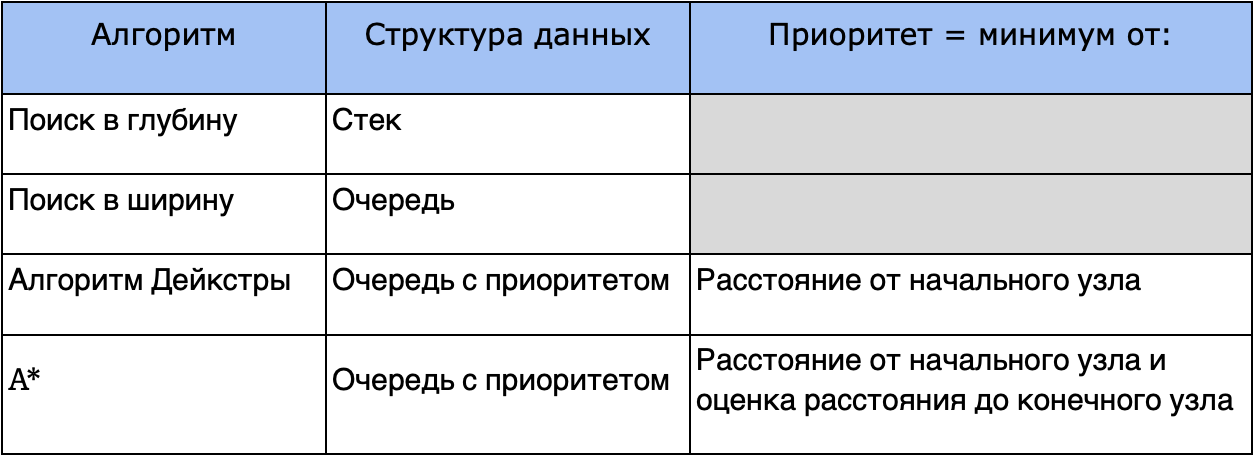

На этом всё. Спасибо за прочтение.